In [28]:
import spacy
import pandas as pd
import pickle
import glob
import numpy as np
import re
import os
from numpy.random import shuffle, seed
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
class Vocab:
    def __init__(self, sentences):
        self.wtoi = {"<sos>": 0, "<eos>": 1, "<unk>": 2, "<pad>": 3}
        self.itow = None
        self.word_count = {}
        self.sentences = sentences
        self.sent_lengths = None

    def build(self, min_freq=2):
        for sentence in self.sentences:
            for tok in sentence:
                if not self.word_count.get(tok):
                    self.word_count[tok] = 1
                else:
                    self.word_count[tok] += 1

        for word in list(self.word_count):
            if self.word_count[word] < min_freq:
                del self.word_count[word]

        idx = 4
        for word in self.word_count:
            self.wtoi[word] = idx
            idx += 1

        self.itow = {i: w for w, i in self.wtoi.items()}

        self.sent_lengths = pd.Series([len(sentence) for sentence in self.sentences])

    def sentence_to_num(self, sentence, max_length):
        if len(sentence) > max_length - 2:
            return None
        idxs = [self.wtoi["<sos>"]]
        for tok in sentence:
            idx = self.wtoi.get(tok)
            if idx is None: idx = self.wtoi["<unk>"]
            idxs.append(idx)
        idxs.append(self.wtoi["<eos>"])
        for i in range(len(sentence) + 2, max_length):
            idxs.append(self.wtoi["<pad>"])

        return idxs

    def num_to_sentence(self, nums):
        sentence = []

        for num in nums:
            if num == self.wtoi["<pad>"] or num == self.wtoi["<sos>"]: continue
            if num == self.wtoi["<eos>"]: break

            sentence.append(self.itow[num])

        return sentence

    def num_to_sentence_batch(self, nums_batch):
        return [self.num_to_sentence(nums) for nums in nums_batch]

    def plot_sent_lengths(self):
        print(self.sent_lengths.value_counts())
        pass

    def save_vocab(self, filename="../vars/vocab.pkl"):
        with open(filename, "wb") as f:
            pickle.dump(self, f)


def get_video_lengths(vocab, datapath="/home/kenny/Workspace/Data/SLT", split="train", side = 227, out_seq_length = 30):
    anno_filename = datapath + "/manual/PHOENIX-2014-T." + split + ".corpus.csv"

    df = pd.read_csv(anno_filename, sep="|")
    spacy_de = spacy.load("de")

    image_path_prefix = datapath + "/open_pose/fullFrame-" + str(side) + "x" + str(side) + "px/" + split + "/"

    video_lengths = []

    for idx in range(df.shape[0]):
        row = df.iloc[idx]

        tokens = [tok.lower_ for tok in spacy_de.tokenizer(row.translation)]
        nums = vocab.sentence_to_num(tokens, out_seq_length)
        if nums is None: continue

        path = image_path_prefix + row.video
        path = path.replace("1/*.png", "*.pkl")
        video_lengths.append(len(list(glob.glob(path))))

    return pd.Series(video_lengths)

In [36]:
with open("../vars/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

video_lengths = get_video_lengths(vocab)

In [32]:
lengths = list(video_lengths.value_counts().index)
nums = list(video_lengths.value_counts())

In [33]:
a = sorted(list(zip(lengths,nums)), key=lambda x: x[0])
lengths = [x[0] for x in a]
nums = [x[1] for x in a]

(array([ 502., 1070., 1834., 1820.,  947.,  492.,  231.,   42.,   13.,
           4.]),
 array([ 16. ,  47.3,  78.6, 109.9, 141.2, 172.5, 203.8, 235.1, 266.4,
        297.7, 329. ]),
 <a list of 10 Patch objects>)

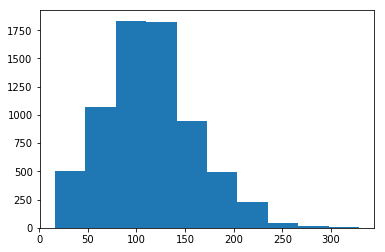

In [47]:
counts, bins = np.histogram(video_lengths)
plt.hist(bins[:-1], bins, weights=counts)


In [50]:
np.sum(video_lengths<100) * 100 / len(video_lengths)

39.108554996405466

In [48]:
bins

array([ 16. ,  47.3,  78.6, 109.9, 141.2, 172.5, 203.8, 235.1, 266.4,
       297.7, 329. ])